In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine  = pudl.connect_db()

In [3]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9 , 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [4]:
# Convert the generators_eia860 table into a dataframe
g8 = analysis.simple_select('generators_eia860', pudl_engine)
g8 = g8[['plant_id','generator_id','nameplate_capacity_mw','summer_capacity_mw','winter_capacity_mw','year']]

In [5]:
# Reformat the year column to a datetime object
g8['year'] = pd.to_datetime(g8['year'], format='%Y')
g8.rename(columns={'year': 'report_date'},inplace=True)
g8 = g8.set_index(pd.DatetimeIndex(g8['report_date']).year)
g8.drop('report_date',axis=1, inplace=True)
g8.reset_index(inplace=True)

In [6]:
# merge the generation and capacity to calculate capacity factor
capacity_factor = g9_summed.merge(g8, on=['plant_id','generator_id','report_date'])
capacity_factor['capacity_factor'] =\
            capacity_factor['net_generation_mwh']/(capacity_factor['nameplate_capacity_mw']*8760)

In [7]:
capacity_factor.capacity_factor.min()

-8.943049213597158

In [8]:
capacity_factor.capacity_factor.max()

11.790228310502282

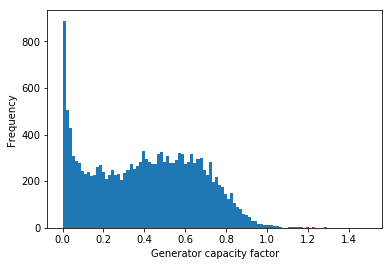

In [12]:
capacity_factor['capacity_factor'].plot(kind='hist', bins=100)
plt.xlabel('Generator capacity factor')
plt.show()

In [10]:
# Remove unrealistic capacity factors: < 0 or > 1.5
capacity_factor = capacity_factor[capacity_factor.capacity_factor > 0]
capacity_factor = capacity_factor[capacity_factor.capacity_factor <= 1.5]

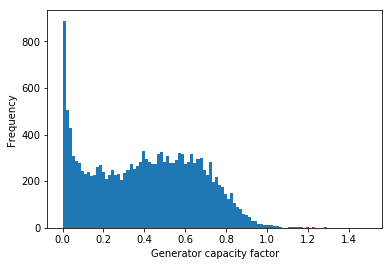

In [11]:
capacity_factor['capacity_factor'].plot(kind='hist', bins=100)
plt.xlabel('Generator capacity factor')
plt.show()